<a href="https://colab.research.google.com/github/vanessaaleung/support-ticket-nlp/blob/master/Support_Ticket_NLP_Case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Support Ticket NLP Case**



*   To identify the main issues in the ticket description
*   To extract the key phrases in the ticket description



In [0]:
import pandas as pd

In [28]:
tickets = pd.read_csv("https://raw.githubusercontent.com/vanessaaleung/rawdata/master/all_tickets.csv")
tickets.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
0,NaN,hi since recruiter lead permission approve req...,1,4,2,21,71,3,4
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4


#### **Topic Modeling**

To identify the main issues in the ticket description

In [29]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

!pip3 install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
documents = tickets.loc[:, 'body'].tolist()
len(documents)

48549

In [31]:
# convert descriptions into a list of tokens
tokens = [gensim.utils.simple_preprocess(one_document, deacc=True) for one_document in documents]

for token in tokens[:3]:
  print(token)

['hi', 'since', 'recruiter', 'lead', 'permission', 'approve', 'requisitions', 'makes', 'please', 'make', 'thanks', 'recruiter']
['icon', 'dear', 'please', 'setup', 'icon', 'per', 'icon', 'engineers', 'please', 'let', 'other', 'details', 'needed', 'thanks', 'lead']
['work', 'experience', 'user', 'hi', 'work', 'experience', 'student', 'coming', 'next', 'his', 'name', 'much', 'appreciate', 'him', 'duration', 'thank']


In [0]:
# build the bigram model to find frequently co-occurring tokens
bigram = gensim.models.Phrases(tokens, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

for token in tokens[:3]:
  print(bigram_mod[token])

['hi', 'since', 'recruiter', 'lead', 'permission', 'approve', 'requisitions', 'makes', 'please', 'make', 'thanks', 'recruiter']
['icon', 'dear', 'please', 'setup', 'icon', 'per', 'icon', 'engineers', 'please', 'let', 'other', 'details', 'needed', 'thanks', 'lead']
['work', 'experience', 'user', 'hi', 'work', 'experience', 'student', 'coming', 'next', 'his', 'name', 'much', 'appreciate', 'him', 'duration', 'thank']


In [0]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatize(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [0]:
tokens_rm_stopwords = remove_stopwords(tokens)
tokens_bigrams = make_bigrams(tokens_rm_stopwords)

nlp = spacy.load('en', disable=['parser', 'ner'])

tokens_lemmatized = lemmatize(tokens_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

for token in tokens_lemmatized[:3]:
  print(token)

['recruiter', 'lead', 'permission', 'approve', 'requisition', 'make', 'make', 'thank', 'recruiter']
['icon', 'dear', 'setup', 'icon', 'icon', 'engineer', 'let', 'detail', 'need', 'thank', 'lead']
['work', 'experience', 'user', 'work', 'experience', 'student', 'come', 'next', 'name', 'much', 'appreciate', 'duration', 'thank']


In [0]:
# create the dictionary and corpus for LDA topic modeling
id2word = corpora.Dictionary(tokens_lemmatized)

corpus = [id2word.doc2bow(text) for text in tokens_lemmatized]

for sentence in corpus[:3]:
  print([(id2word[word_id], word_freq) for (word_id, word_freq) in sentence])

[('approve', 1), ('lead', 1), ('make', 2), ('permission', 1), ('recruiter', 2), ('requisition', 1), ('thank', 1)]
[('lead', 1), ('thank', 1), ('dear', 1), ('detail', 1), ('engineer', 1), ('icon', 3), ('let', 1), ('need', 1), ('setup', 1)]
[('thank', 1), ('appreciate', 1), ('come', 1), ('duration', 1), ('experience', 2), ('much', 1), ('name', 1), ('next', 1), ('student', 1), ('user', 1), ('work', 2)]


Find the optimal number of topics

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=0)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=tokens_lemmatized, start=2, limit=40, step=6)

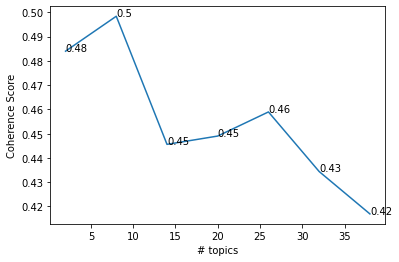

In [0]:
limit=40
start=2
step=6
x = range(start, limit, step)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(x, coherence_values)
for i,j in zip(x,coherence_values):
    ax.annotate(round(j, 2),xy=(i,j))
plt.xlabel("# topics")
plt.ylabel("Coherence Score")
plt.show()

In [0]:
# build the LDA model
num_topics = 10

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=0)
pprint(lda_model.print_topics())

[(0,
  '0.162*"send" + 0.016*"access" + 0.016*"would" + 0.014*"issue" + '
  '0.013*"follow" + 0.012*"contact" + 0.012*"thank" + 0.012*"error" + '
  '0.011*"check" + 0.011*"could"'),
 (1,
  '0.077*"form" + 0.051*"message" + 0.045*"officer" + 0.042*"date" + '
  '0.042*"thank" + 0.040*"attach" + 0.033*"fill" + 0.029*"leaver" + '
  '0.029*"starter" + 0.027*"find"'),
 (2,
  '0.035*"thank" + 0.033*"regard" + 0.030*"add" + 0.027*"detail" + '
  '0.023*"assign" + 0.021*"name" + 0.021*"ticket" + 0.020*"confluence" + '
  '0.020*"request" + 0.015*"task"'),
 (3,
  '0.053*"error" + 0.038*"submit" + 0.036*"card" + 0.031*"thank" + '
  '0.031*"leave" + 0.026*"try" + 0.023*"issue" + 0.023*"day" + 0.022*"manager" '
  '+ 0.021*"could"'),
 (4,
  '0.079*"report" + 0.065*"approval" + 0.033*"action" + 0.027*"expense" + '
  '0.026*"line" + 0.020*"number" + 0.016*"ca" + 0.015*"require" + 0.014*"date" '
  '+ 0.013*"information"'),
 (5,
  '0.038*"access" + 0.032*"password" + 0.027*"use" + 0.021*"user" + '
  '0.02

In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.122570 -0.009639       1        1  19.567030
0      0.148047 -0.086219       2        1  14.225424
2      0.007426  0.072603       3        1  12.421255
7     -0.017431 -0.012592       4        1   9.379757
3      0.108053 -0.090982       5        1   9.240642
5      0.073663  0.019129       6        1   8.556944
6     -0.039139  0.171631       7        1   8.516135
4      0.062826 -0.121428       8        1   6.853247
1     -0.112200  0.233009       9        1   6.190266
9     -0.353815 -0.175512      10        1   5.049306, topic_info=          Term          Freq         Total Category  logprob  loglift
403       send  27050.000000  27050.000000  Default  30.0000  30.0000
129     report   7091.000000   7091.000000  Default  29.0000  29.0000
365       form   5829.000000   5829.000000  Default  28.0000  28.0000
748   approval   5469.000000   5469.000000  Default  27.0000  27.0000
103      error   9032.000000   9032.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
6        thank    928.454956  35682.605469  Topic10  -4.1569  -0.6630
246   wireless    342.637695    645.329712  Topic10  -5.1537   2.3528
22        user    459.722900   2944.497314  Topic10  -4.8598   1.1288
262     number    431.080200   4938.458984  Topic10  -4.9241   0.5474
8069     could    376.497528  10151.221680  Topic10  -5.0595  -0.3085

[752 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1071      9  0.981812   abroad
130       5  0.698790  absence
130       8  0.298304  absence
130       9  0.001648  absence
817       1  0.095096   access
...     ...       ...      ...
380       8  0.037694    write
380       9  0.006389    write
380      10  0.000639    write
3366      5  0.962205  wrongly
1724      6  0.995230   yellow

[2280 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 1, 3, 8, 4, 6, 7, 5, 2, 10])

##### **pytextrank**

To extract the key phrases in the ticket description

In [0]:
!pip install pytextrank
import pytextrank
import spacy

In [34]:
# text = tickets.loc[0, 'description']
nlp = spacy.load("en_core_web_sm")

# add PyTextRank into the spaCy pipeline
tr = pytextrank.TextRank(logger=None)
nlp.add_pipe(tr.PipelineComponent, name="textrank", last=True)

doc = nlp(documents[0])

for phrase in doc._.phrases[:5]:
    print("{:.4f} {:5d}  {}".format(phrase.rank, phrase.count, phrase.text))

0.1756     1  permission
0.1742     1  requisitions
0.1416     1  recruiter


#### **Explain PyTextRank: the algorithm**

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [0]:
doc = nlp(documents[0])

Use NetworkX to manage an in-memory graph

In [0]:
import networkx as nx

def increment_edge (graph, node0, node1):
    print("link {} {}".format(node0, node1))
    
    if graph.has_edge(node0, node1):
        graph[node0][node1]["weight"] += 1.0
    else:
        graph.add_edge(node0, node1, weight=1.0)

Construct a graph, sentence by sentence, based on the spaCy part-of-speech tags tags

In [0]:
POS_KEPT = ["ADJ", "NOUN", "PROPN", "VERB"]

def link_sentence (doc, sent, lemma_graph, seen_lemma):
    visited_tokens = []
    visited_nodes = []

    for i in range(sent.start, sent.end):
        token = doc[i]

        if token.pos_ in POS_KEPT:
            key = (token.lemma_, token.pos_)

            if key not in seen_lemma:
                seen_lemma[key] = set([token.i])
            else:
                seen_lemma[key].add(token.i)

            node_id = list(seen_lemma.keys()).index(key)

            if not node_id in lemma_graph:
                lemma_graph.add_node(node_id)

            print("visit {} {}".format(visited_tokens, visited_nodes))
            print("range {}".format(list(range(len(visited_tokens) - 1, -1, -1))))
            
            for prev_token in range(len(visited_tokens) - 1, -1, -1):
                print("prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])))
                
                if (token.i - visited_tokens[prev_token]) <= 3:
                    increment_edge(lemma_graph, node_id, visited_nodes[prev_token])
                else:
                    break

            print(" -- {} {} {} {} {} {}".format(token.i, token.text, token.lemma_, token.pos_, visited_tokens, visited_nodes))

            visited_tokens.append(token.i)
            visited_nodes.append(node_id)

In [41]:
lemma_graph = nx.Graph()
seen_lemma = {}

for sent in doc.sents:
    link_sentence(doc, sent, lemma_graph, seen_lemma)

visit [] []
range []
 -- 2 recruiter recruiter NOUN [] []
visit [2] [0]
range [0]
prev_tok 0 1
link 1 0
 -- 3 lead lead NOUN [2] [0]
visit [2, 3] [0, 1]
range [1, 0]
prev_tok 1 1
link 2 1
prev_tok 0 2
link 2 0
 -- 4 permission permission NOUN [2, 3] [0, 1]
visit [2, 3, 4] [0, 1, 2]
range [2, 1, 0]
prev_tok 2 1
link 3 2
prev_tok 1 2
link 3 1
prev_tok 0 3
link 3 0
 -- 5 approve approve VERB [2, 3, 4] [0, 1, 2]
visit [2, 3, 4, 5] [0, 1, 2, 3]
range [3, 2, 1, 0]
prev_tok 3 1
link 4 3
prev_tok 2 2
link 4 2
prev_tok 1 3
link 4 1
prev_tok 0 4
 -- 6 requisitions requisition NOUN [2, 3, 4, 5] [0, 1, 2, 3]
visit [2, 3, 4, 5, 6] [0, 1, 2, 3, 4]
range [4, 3, 2, 1, 0]
prev_tok 4 1
link 5 4
prev_tok 3 2
link 5 3
prev_tok 2 3
link 5 2
prev_tok 1 4
 -- 7 makes make VERB [2, 3, 4, 5, 6] [0, 1, 2, 3, 4]
visit [2, 3, 4, 5, 6, 7] [0, 1, 2, 3, 4, 5]
range [5, 4, 3, 2, 1, 0]
prev_tok 5 2
link 5 5
prev_tok 4 3
link 5 4
prev_tok 3 4
 -- 9 make make VERB [2, 3, 4, 5, 6, 7] [0, 1, 2, 3, 4, 5]
visit [2, 3, 4, 5,

Collect a dictionary of the labels

In [0]:
labels = {}
keys = list(seen_lemma.keys())

for i in range(len(seen_lemma)):
    labels[i] = keys[i][0].lower()

Use matplotlib to visualize the lemma graph

{0: Text(0.9150546287267006, 0.056530723524730576, 'recruiter'),
 1: Text(0.6583681606598226, -0.3405076529479405, 'lead'),
 2: Text(0.3417795155657946, 0.1584220988099277, 'permission'),
 3: Text(0.34122762367032133, -0.1457242844612758, 'approve'),
 4: Text(0.010854971091552132, -0.25340591370335536, 'requisition'),
 5: Text(-0.35908032812078644, 0.05834328714248461, 'make'),
 6: Text(-0.908204571593405, 0.024056839372323568, 'thank'),
 7: Text(-1.0, 0.442284902263105, 'recruiter')}

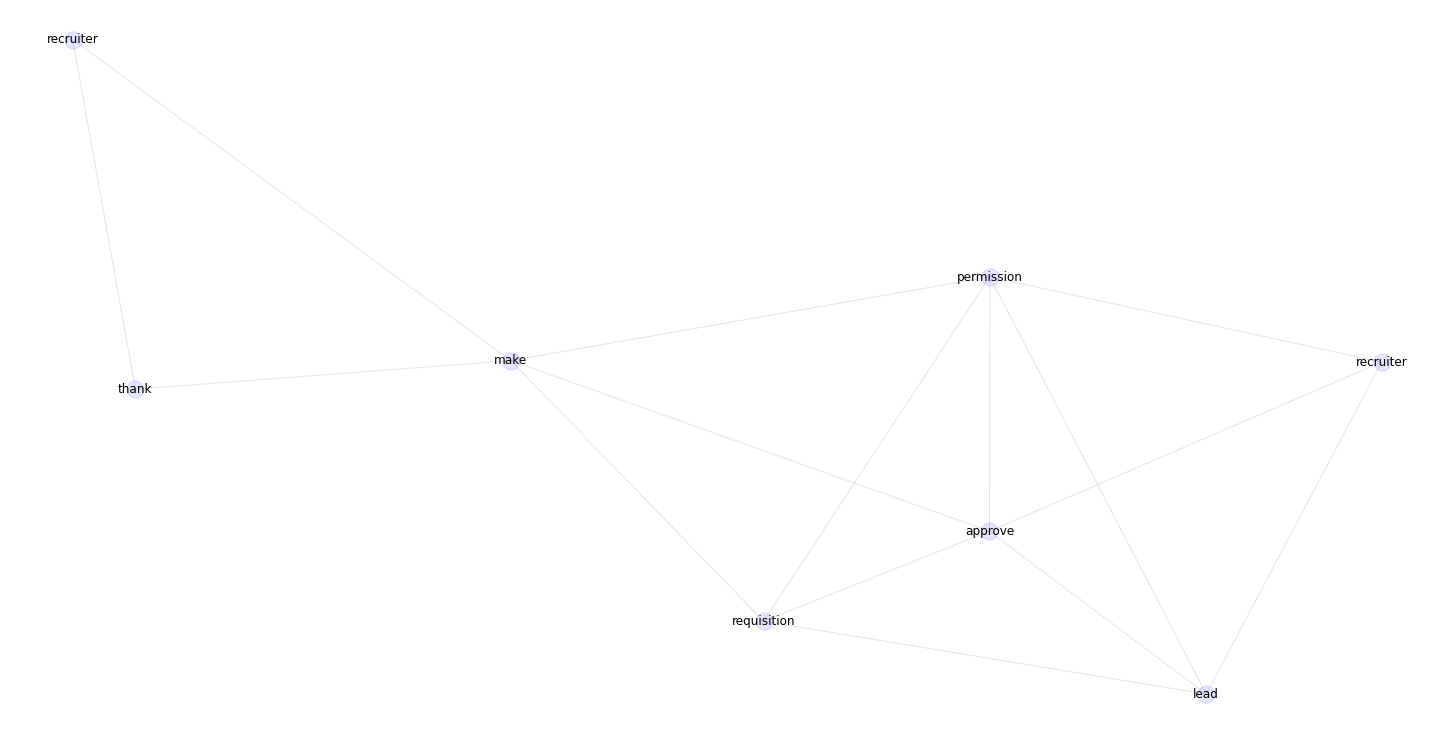

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))
pos = nx.spring_layout(lemma_graph)  # pos[node] = position

nx.draw(lemma_graph, pos=pos, with_labels=False, font_weight="bold", node_color='b', alpha=0.1)
nx.draw_networkx_labels(lemma_graph, pos, labels)

Use PageRank – which is approximately [eigenvalue centrality](https://en.wikipedia.org/wiki/Eigenvector_centrality) – to calculate ranks for each of the nodes in the lemma graph

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/97138b5e39ce8a24e0ee2e411d4c4d0a3513ec42)



*   $a_{v,t}=1$ if vertex $v$ is linked to vertex $t$, and $a_{v,t}=0$ otherwise
*   $M(v)$ is a set of the neighbors of $v$ and $\lambda$  is a constant



In [44]:
rank_df = pd.DataFrame(columns=['rank', 'label'])

ranks = nx.pagerank(lemma_graph)
for node_id, rank in sorted(ranks.items(), key=lambda x: x[1], reverse=True):
    rank_df = rank_df.append(pd.Series([rank, labels[node_id]], index=rank_df.columns), ignore_index=True)

rank_df[:10]

,rank,label
0,0.218122,make
1,0.138681,approve
2,0.138681,permission
3,0.136627,requisition
4,0.114706,lead
5,0.094272,thank
6,0.090276,recruiter
7,0.068636,recruiter


Collect the top-ranked phrases from the lemma graph based on the noun chunks

In [0]:
import math

def collect_phrases (chunk, phrases, counts):
    chunk_len = chunk.end - chunk.start + 1
    sq_sum_rank = 0.0
    non_lemma = 0
    compound_key = set([])

    for i in range(chunk.start, chunk.end):
        token = doc[i]
        key = (token.lemma_, token.pos_)
        
        if key in seen_lemma:
            node_id = list(seen_lemma.keys()).index(key)
            rank = ranks[node_id]
            sq_sum_rank += rank
            compound_key.add(key)
        
        else:
            non_lemma += 1
    
    # discount the ranks using a point estimate based on the number of non-lemma tokens within a phrase
    non_lemma_discount = chunk_len / (chunk_len + (2.0 * non_lemma) + 1.0)

    # use root mean square (RMS) to normalize the contributions of all the tokens
    phrase_rank = math.sqrt(sq_sum_rank / (chunk_len + non_lemma))
    phrase_rank *= non_lemma_discount

    # remove spurious punctuation
    phrase = chunk.text.lower().replace("'", "")

    # create a unique key for the the phrase based on its lemma components
    compound_key = tuple(sorted(list(compound_key)))
    
    if not compound_key in phrases:
        phrases[compound_key] = set([ (phrase, phrase_rank) ])
        counts[compound_key] = 1
    else:
        phrases[compound_key].add( (phrase, phrase_rank) )
        counts[compound_key] += 1

    return [phrase_rank, chunk.text, counts[compound_key]]

In [46]:
phrases = {}
counts = {}

phrase_rank = pd.DataFrame(columns=['phrase_rank', 'chunk_text', 'counts'])
for chunk in doc.noun_chunks:
    
    phrase_rank = phrase_rank.append(pd.Series(collect_phrases(chunk, phrases, counts), index=phrase_rank.columns), ignore_index=True)

phrase_rank.sort_values(by='phrase_rank', ascending=False)[:10]

,phrase_rank,chunk_text,counts
1,0.175550,permission,1
2,0.174246,requisitions,1
0,0.141638,recruiter,1


Find a minimum span for each phrase based on combinations of lemmas

In [47]:
import operator

min_phrases = {}

for compound_key, rank_tuples in phrases.items():
    l = list(rank_tuples)
    l.sort(key=operator.itemgetter(1), reverse=True)
    
    phrase, rank = l[0]
    count = counts[compound_key]
    
    min_phrases[phrase] = (rank, count)
    
min_phrases

{'permission': (0.17555037929471423, 1),
 'recruiter': (0.1416381454134179, 1),
 'requisitions': (0.1742458175386728, 1)}

In [48]:
for phrase, (rank, count) in sorted(min_phrases.items(), key=lambda x: x[1][0], reverse=True):
    print(phrase, count, rank)

permission 1 0.17555037929471423
requisitions 1 0.1742458175386728
recruiter 1 0.1416381454134179
